## Preambule

In [1]:
import numpy as np
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Run classes

In [2]:
import class_datareading
reload(class_datareading)
from class_datareading import datareading

datareader = datareading()
datareader.read_general()
datareader.read_ssps()
datareader.read_undata()
datareader.read_historicalemis()
datareader.read_ar6()
datareader.relation_budget_nonco2()
datareader.determine_global_nonco2_trajectories()
datareader.determine_global_budgets()
datareader.determine_global_co2_trajectories()
datareader.read_baseline()
datareader.read_ndc() 
datareader.merge_xr()
datareader.add_country_groups()
datareader.save()

# ==================================== #
# Initializing datareading class     #
# ==================================== #
- Reading general data
- Reading GDP and population data from SSPs
- Reading UN population data (for past population)
- Reading historical emissions (primap)
- Read AR6 data
- Get relationship between CO2 budgets and non-co2 reduction in 2050
- Computing global nonco2 trajectories
- Get global CO2 budgets
- Computing global co2 trajectories
- Reading baseline emissions
- Reading NDC data
- Merging xrarray object
- Add country groups
- Save important files
- Some pre-calculations for the AP allocation rule


In [2]:
import class_allocation

reload(class_allocation)
from class_allocation import allocation

for cty in ['NLD']:#tqdm(np.array(datareader.xr_total.Region)):
    allocator = allocation(cty)
    allocator.gf()  
    allocator.pc()
    allocator.pcc()
    allocator.ecpc()
    allocator.ap()
    allocator.gdr()
    # allocator.save()

In [7]:
xr_old = xr.open_dataset("K:/ECEMF/T5.2/Allocations/xr_alloc_NLD.nc").load()

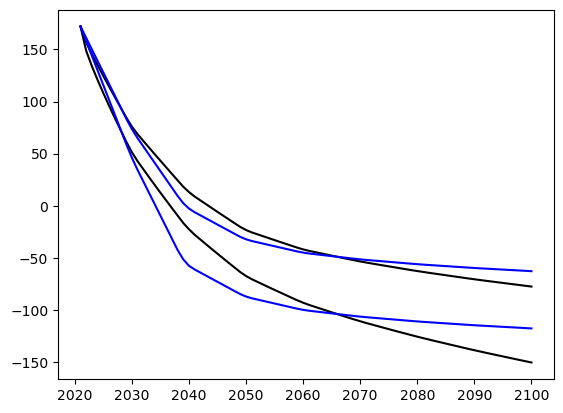

In [12]:
plt.plot(allocator.xr_total.Time, allocator.xr_total.sel(Temperature=1.5, NegEmis=0.5, NonCO2red=0.5, Risk=0.5, Timing='Immediate').ECPC.max(dim=['Historical_startyear', 'Discount_factor', 'Scenario']), c='k')
plt.plot(allocator.xr_total.Time, allocator.xr_total.sel(Temperature=1.5, NegEmis=0.5, NonCO2red=0.5, Risk=0.5, Timing='Immediate').ECPC.min(dim=['Historical_startyear', 'Discount_factor', 'Scenario']), c='k')

plt.plot(xr_old.Time, xr_old.sel(Temperature=1.5, NegEmis=0.5, NonCO2red=0.5, Risk=0.5, Timing='Immediate').ECPC.max(dim=['Historical_startyear', 'Discount_factor', 'Scenario']), c='b')
plt.plot(xr_old.Time, xr_old.sel(Temperature=1.5, NegEmis=0.5, NonCO2red=0.5, Risk=0.5, Timing='Immediate').ECPC.min(dim=['Historical_startyear', 'Discount_factor', 'Scenario']), c='b')

In [6]:
import class_allocation

reload(class_allocation)
from class_allocation import allocation

for cty in tqdm(np.array(datareader.xr_total.Region)):
    allocator = allocation(cty)
    allocator.gf()  
    allocator.pc()
    allocator.pcc()
    allocator.ecpc()
    allocator.ap()
    allocator.gdr()
    allocator.save()

100%|██████████| 207/207 [1:32:29<00:00, 26.81s/it]


In [2]:
import class_tempalign
reload(class_tempalign)
from class_tempalign import tempaligning

tempaligner = tempaligning() # FIRST RUN AGGREGATOR FOR THIS!! (2030 alloc)
tempaligner.get_relation_2030emis_temp()
tempaligner.determine_tempoutcomes()
tempaligner.save()

# ==================================== #
# Initializing tempaligning class        #
# ==================================== #
- Determine relation between 2030-emissions and temperature outcome
- Determine temperature metric


100%|██████████| 6/6 [00:23<00:00,  3.90s/it]


- Save


In [5]:
import class_policyscens
reload(class_policyscens)
from class_policyscens import policyscenadding

policyscenner = policyscenadding()
policyscenner.read_engage_data()
policyscenner.filter_and_convert()
policyscenner.add_to_xr()

# ==================================== #
# Initializing policyscenadding class  #
# ==================================== #
- Read ENGAGE scenarios and change region namings
- Filter correct scenarios and convert to xarray object
- Add to overall xrobject
